<a href="https://colab.research.google.com/github/ritesh2448/Text-Detection-And-Recognition/blob/master/Text%20detection%20module/YOLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from gdrive.MyDrive.mini_project import preprocessing

In [ ]:
random.seed(10)
X,Y = preprocessing.preprocess("/content/gdrive/MyDrive/mini_project/")

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [ ]:
np.save('/content/gdrive/MyDrive/mini_project/X.npy', X)
np.save('/content/gdrive/MyDrive/mini_project/Y.npy', Y)

In [ ]:
X = np.load('/content/gdrive/MyDrive/mini_project/X.npy')
Y = np.load('/content/gdrive/MyDrive/mini_project/Y.npy')

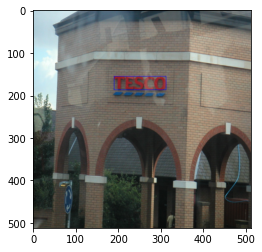

In [ ]:
preprocessing.show_random(X,Y)

In [ ]:
# Get X,Y from preprocess.py
# def normalize(X):
#   X.astype('float')
#   X[:,:,:,0] = (X[:,:,:,0]-123.68)/58.393
#   X[:,:,:,1] = (X[:,:,:,1]-116.779)/57.12
#   X[:,:,:,2] = (X[:,:,:,2]-103.939)/57.375
#   return X
 
# def denormalize(X):
#   X[:,:,:,0] = X[:,:,:,0]*58.393 + 123.68
#   X[:,:,:,1] = X[:,:,:,1]*57.12 + 116.779
#   X[:,:,:,2] = X[:,:,:,2]*57.375 + 103.939
#   X.astype('int')
#   return X
 
def test_train_split(X,Y,test_percent = 0.05):
  ind_list = list(range(X.shape[0]))
  random.shuffle(ind_list)
  X  = X[ind_list,:,:,:]
  Y = Y[ind_list,:,:,:]
  split_idx = int(X.shape[0]*test_percent)
  X_test = X[:split_idx]
  Y_test = Y[:split_idx]
  X_train = X[split_idx:]
  Y_train = Y[split_idx:]
  return X_train,Y_train,X_test,Y_test

In [ ]:
X_train,Y_train,X_test,Y_test = test_train_split(X,Y)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(438, 512, 512, 3)
(23, 512, 512, 3)
(438, 16, 16, 5)
(23, 16, 16, 5)


In [ ]:
from keras.applications.resnet50 import ResNet50

In [ ]:
def yolo_loss(y_true,y_pred):
   no_obj = (1 - y_true[:,:,:,0])*0.5
   coords = y_true[:,:,:,0]*5
   c_loss = K.sum(K.square(y_true[:,:,:,0]-y_pred[:,:,:,0])*no_obj)
   c_loss1 =  K.sum(K.square(y_true[:,:,:,0]-y_pred[:,:,:,0])*coords)
   w_loss = K.sum(K.square(K.sqrt(y_true[:,:,:,3])-K.sqrt(y_pred[:,:,:,3]))*coords)
   h_loss = K.sum(K.square(K.sqrt(y_true[:,:,:,4])-K.sqrt(y_pred[:,:,:,4]))*coords)
   x_loss = K.sum(K.square(y_true[:,:,:,1]-y_pred[:,:,:,1])*coords)
   y_loss = K.sum(K.square(y_true[:,:,:,2]-y_pred[:,:,:,2])*coords)
   loss = c_loss + c_loss1 + w_loss + h_loss + x_loss + y_loss
   return loss

def yolo_model():
 
  res = ResNet50(include_top=False, input_shape=(512, 512, 3))
  # mark loaded layers as not trainable
  res.trainable = False
  model = tf.keras.Sequential()
  model.add(res)

  model.add(tf.keras.layers.Conv2D(1024,(1,1),padding='same'))
  model.add(tf.keras.layers.LeakyReLU(0.1))
  model.add(tf.keras.layers.Dropout(0.4))
  model.add(tf.keras.layers.BatchNormalization())

  model.add(tf.keras.layers.Conv2D(256,(1,1),padding='same'))
  model.add(tf.keras.layers.LeakyReLU(0.1))
  model.add(tf.keras.layers.Dropout(0.4))
  model.add(tf.keras.layers.BatchNormalization())
  
  model.add(tf.keras.layers.Conv2D(128,(1,1),padding='same'))
  model.add(tf.keras.layers.LeakyReLU(0.1))
  model.add(tf.keras.layers.Dropout(0.4))
  model.add(tf.keras.layers.BatchNormalization())
  
  model.add(tf.keras.layers.Conv2D(32,(1,1),padding='same'))
  model.add(tf.keras.layers.LeakyReLU(0.1))
  model.add(tf.keras.layers.Dropout(0.4))
  model.add(tf.keras.layers.BatchNormalization())
  
  model.add(tf.keras.layers.Conv2D(5,(1,1),padding='same',activation='relu'))
  return model

In [ ]:
model = yolo_model()
model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 16, 16, 2048)      23587712  
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 1024)      2098176   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16, 16, 1024)      0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 1024)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 1024)      4096      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 256)       262400    
_________________________________________________________

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss=yolo_loss, metrics=["accuracy"])
model.fit(x=X_train,y=Y_train,batch_size=16,epochs=20,validation_split=0.05)

Epoch 1/20
26/26 [==============================] - 20s 600ms/step - loss: 189.2668 - accuracy: 0.0823 - val_loss: 188.7522 - val_accuracy: 0.1092
Epoch 2/20
26/26 [==============================] - 14s 552ms/step - loss: 177.3480 - accuracy: 0.0811 - val_loss: 193.1076 - val_accuracy: 0.1067
Epoch 3/20
26/26 [==============================] - 14s 552ms/step - loss: 193.2519 - accuracy: 0.0827 - val_loss: 191.0428 - val_accuracy: 0.1007
Epoch 4/20
26/26 [==============================] - 14s 550ms/step - loss: 189.0588 - accuracy: 0.0808 - val_loss: 193.9114 - val_accuracy: 0.1017
Epoch 5/20
26/26 [==============================] - 14s 552ms/step - loss: 178.3986 - accuracy: 0.0797 - val_loss: 190.7786 - val_accuracy: 0.1030
Epoch 6/20
26/26 [==============================] - 14s 551ms/step - loss: 175.8635 - accuracy: 0.0793 - val_loss: 190.8422 - val_accuracy: 0.1010
Epoch 7/20
26/26 [==============================] - 14s 551ms/step - loss: 173.5593 - accuracy: 0.0797 - val_loss: 192

In [ ]:
Y_pred = model.predict(X_test)

In [ ]:
def show_random_pred(X,Y):
 
  grid_size = 16
  img_size = 512
  per_grid_pix = img_size//grid_size
  idx = random.randint(0,X.shape[0]-1)
  img = X[idx].copy()
  for i in range(Y.shape[1]):
      for j in range(Y.shape[2]):
          if Y[idx][i][j][0]>=0.5:
              x1 = Y[idx][i][j][1]*per_grid_pix + j*per_grid_pix - (Y[idx][i][j][3]*img_size)/2
              x2 = Y[idx][i][j][1]*per_grid_pix + j*per_grid_pix + (Y[idx][i][j][3]*img_size)/2
              y1 = Y[idx][i][j][2]*per_grid_pix + i*per_grid_pix - (Y[idx][i][j][4]*img_size)/2
              y2 = Y[idx][i][j][2]*per_grid_pix + i*per_grid_pix + (Y[idx][i][j][4]*img_size)/2
              cv2.rectangle(img,(int(x1),int(y1)),(int(x2),int(y2)),(0,0,255),2)
  plt.imshow(img)
  plt.show()

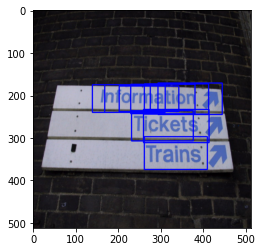

In [ ]:
show_random_pred(X_test,model.predict(X_test))

In [ ]:
model.save('/content/gdrive/MyDrive/mini_project/yolo_model3.h5')

In [ ]:
model = keras.models.load_model('/content/gdrive/MyDrive/mini_project/yolo_model3.h5',custom_objects={'yolo_loss': yolo_loss})

In [ ]:
def gen_bounding_boxes(X,Y):
  grid_size = 16
  img_size = 512
  per_grid_pix = img_size//grid_size
  idx = random.randint(0,X.shape[0]-1)
  img = X[idx].copy()
  bounding_boxes = []
  scores = []
  for i in range(Y.shape[1]):
      for j in range(Y.shape[2]):
          if Y[idx][i][j][0]>=0.4:
              x1 = Y[idx][i][j][1]*per_grid_pix + j*per_grid_pix - (Y[idx][i][j][3]*img_size)/2
              x2 = Y[idx][i][j][1]*per_grid_pix + j*per_grid_pix + (Y[idx][i][j][3]*img_size)/2
              y1 = Y[idx][i][j][2]*per_grid_pix + i*per_grid_pix - (Y[idx][i][j][4]*img_size)/2
              y2 = Y[idx][i][j][2]*per_grid_pix + i*per_grid_pix + (Y[idx][i][j][4]*img_size)/2
              bounding_boxes.append([int(y1),int(x1),int(y2),int(x2)])
              scores.append(Y[idx][i][j][0])
  t_bounding_boxes = nn(bounding_boxes,scores)
  for i in t_bounding_boxes:
    cv2.rectangle(img,(int(i[1]),int(i[0])),(int(i[3]),int(i[2])),(0,0,255),2)
  plt.imshow(img)
  plt.show() 


def iou(b1,b2):
  inter_x1 = max(b1[1],b2[1])
  inter_y1 = max(b1[0],b2[0])
  inter_x2 = min(b1[3],b2[3])
  inter_y2 = min(b1[2],b2[2])

  inter_width = (inter_x2 - inter_x1) if (inter_x2 - inter_x1)>0 else 0
  inter_height = (inter_y2 - inter_y1) if (inter_y2 - inter_y1)>0 else 0
  inter_area = inter_width*inter_height

  b1_area = abs((b1[0] - b1[2])*(b1[1] - b1[3]))
  b2_area = abs((b2[0] - b2[2])*(b2[1] - b2[3]))
  return inter_area/(b1_area+b2_area)


def nn(bounding_boxes,scores):
  #scores = [] 
  #for b in bounding_boxes:
    #scores.append(abs((b[0] - b[2])*(b[1] - b[3])))
  indices = tf.image.non_max_suppression(bounding_boxes, scores,256,iou_threshold=0.5)
  true_bounding_boxes = []
  for i in indices:
    true_bounding_boxes.append(bounding_boxes[i])
  return true_bounding_boxes
'''

def nn(bounding_boxes):
  areas = {}
  for i in range(len(bounding_boxes)):
    areas[i] = abs((bounding_boxes[i][0] - bounding_boxes[i][2])*(bounding_boxes[i][1] - bounding_boxes[i][3]))
  indices = []
  while True:
    index = max(areas, key=areas.get)
    if areas[index]<0:
      break
    areas[index] = -1
    indices.append(index)
    for i in range(len(bounding_boxes)):
      if areas[i]>0 and iou(bounding_boxes[index],bounding_boxes[i])>0.4:
        areas[i] = -1
  true_bounding_boxes = []
  for i in indices:
    true_bounding_boxes.append(bounding_boxes[i])
  return true_bounding_boxes
'''

'\n\ndef nn(bounding_boxes):\n  areas = {}\n  for i in range(len(bounding_boxes)):\n    areas[i] = abs((bounding_boxes[i][0] - bounding_boxes[i][2])*(bounding_boxes[i][1] - bounding_boxes[i][3]))\n  indices = []\n  while True:\n    index = max(areas, key=areas.get)\n    if areas[index]<0:\n      break\n    areas[index] = -1\n    indices.append(index)\n    for i in range(len(bounding_boxes)):\n      if areas[i]>0 and iou(bounding_boxes[index],bounding_boxes[i])>0.4:\n        areas[i] = -1\n  true_bounding_boxes = []\n  for i in indices:\n    true_bounding_boxes.append(bounding_boxes[i])\n  return true_bounding_boxes\n'

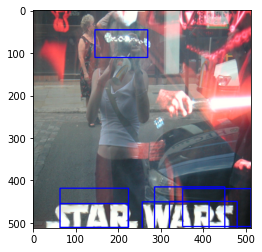

In [ ]:
gen_bounding_boxes(X_test,model.predict(X_test))